In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun  1 13:52:31 2021

@author: marioc
"""

#%% LIBRERIAS
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
!pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries
import matplotlib.dates as mdates
from datetime import datetime
import pandas as pd

     |████████████████████████████████| 1.3 MB 35.9 MB/s 
     |████████████████████████████████| 142 kB 65.7 MB/s 
     |████████████████████████████████| 294 kB 50.7 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/i

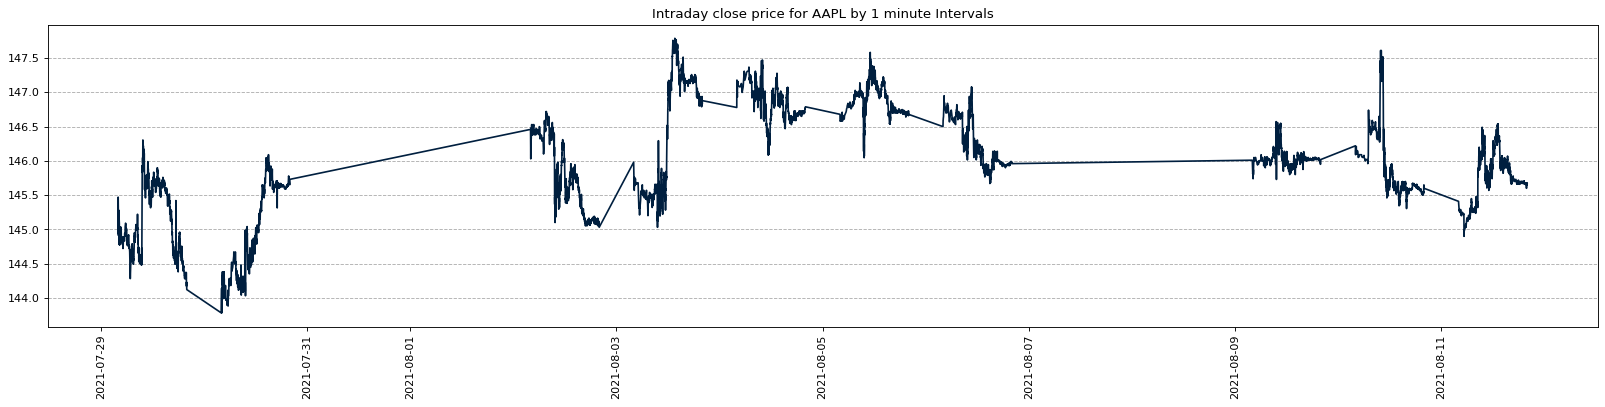

In [ ]:
key="19UAFYJH9XMTRHML"

#%% PREPARACION DE DATOS

ts = TimeSeries(key=key, output_format='pandas')
data, meta_data = ts.get_intraday(symbol='AAPL',interval='1min', outputsize='full')
close_data = data['4. close']

data['tickDirection'] = ['']*len(data)
data['tickDirection'][0] = 'ZeroPlusTick'
for i in range(len(data)-1):
    if data['4. close'][i+1] > data['4. close'][i]:
        data['tickDirection'][i+1] = 'PlusTick'
    elif data['4. close'][i+1] == data['4. close'][i] and (data['tickDirection'][i] == 'PlusTick' or data['tickDirection'][i] == 'ZeroPlusTick'):
        data['tickDirection'][i+1] = 'ZeroPlusTick'
    elif data['4. close'][i+1] == data['4. close'][i] and (data['tickDirection'][i] != 'PlusTick' or data['tickDirection'][i] != 'ZeroPlusTick'):
        data['tickDirection'][i+1] = 'ZeroMinusTick'
    else:
        data['tickDirection'][i+1] = 'MinusTick'

num_data_points_df = len(data)

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data.index, close_data, color="#001f3f")
plt.xticks(rotation='vertical')
plt.title("Intraday close price for AAPL by 1 minute Intervals")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.show()

close_data_arr = np.array(close_data)

In [ ]:
def compute_vwap(df):
    p = df['4. close']
    q = df['5. volume']
    vwap = np.sum(p*q)/np.sum(q)
    df['vwap'] = vwap
    return df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


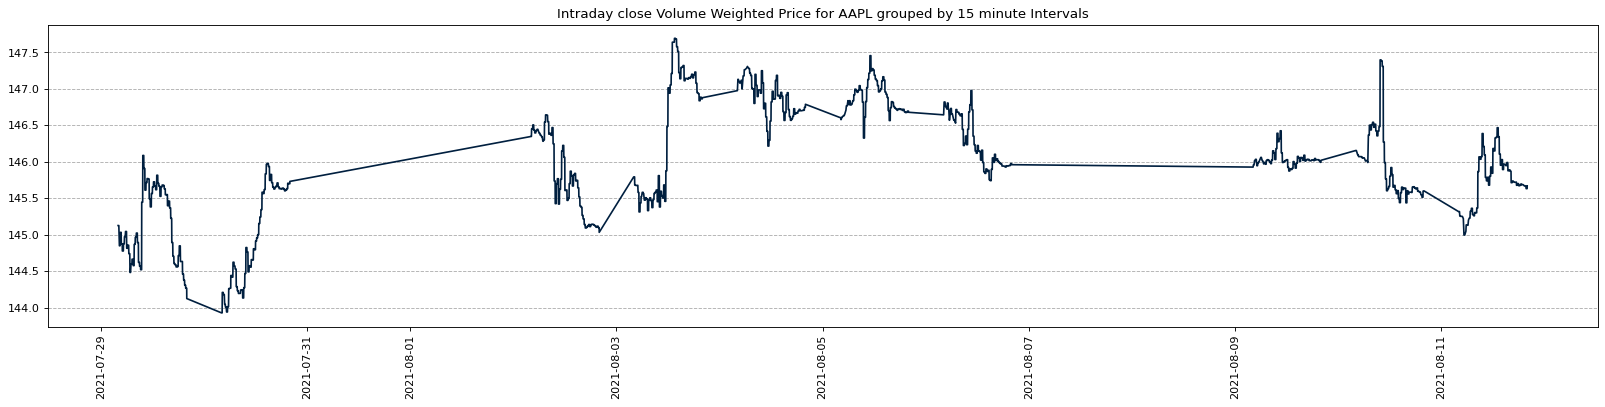

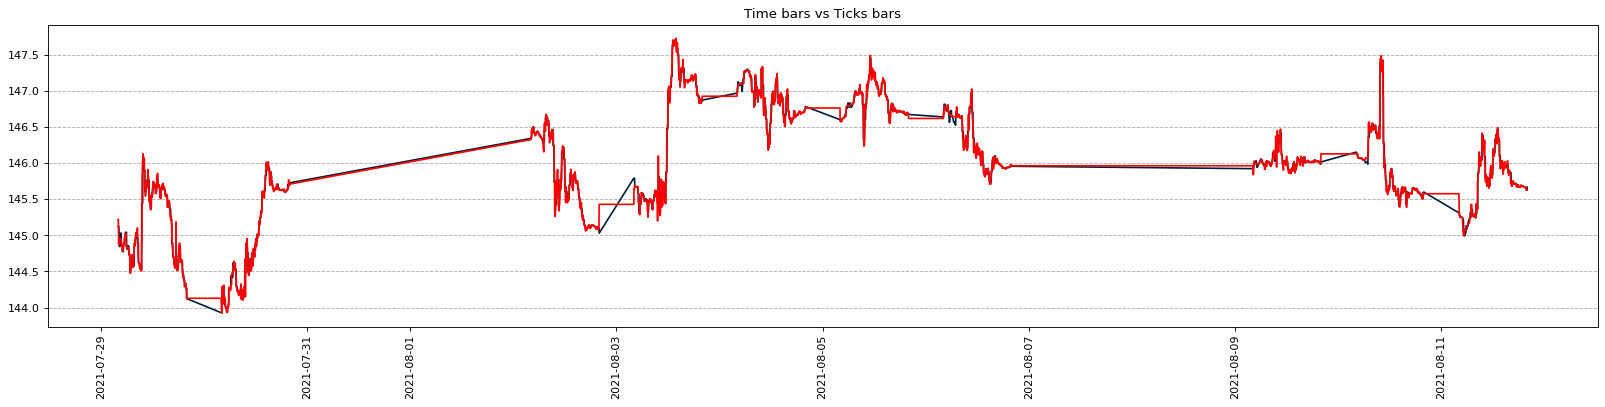

In [ ]:
# time bars
data_timeidx = data
data_time_grp = data_timeidx.groupby(pd.Grouper(freq = '15Min'))
num_time_bars = len(data_time_grp)
data_time_vwap = data_time_grp.apply(compute_vwap)

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_time_vwap.index, data_time_vwap['vwap'], color="#001f3f")
plt.xticks(rotation='vertical')
plt.title("Intraday close Volume Weighted Price for AAPL grouped by 15 minute Intervals")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.show()

# dollar bars
total_ticks = len(data)
num_ticks_per_bar = total_ticks/num_time_bars
# num_ticks_per_bar = round(num_ticks_per_bar, -3)
data_tick_grp = data.reset_index().assign(grpId = lambda row: row.index//num_ticks_per_bar)

data_tick_vwap = data_tick_grp.groupby('grpId').apply(compute_vwap)
data_tick_vwap.set_index('date', inplace=True)


fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_time_vwap.index, data_time_vwap['vwap'], color="#001f3f")
plt.plot(data_tick_vwap.index, data_tick_vwap.vwap, color="#FF0000")
plt.xticks(rotation='vertical')
plt.title("Time bars vs Ticks bars")
plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.show()

In [ ]:
# imbalance bars

def convert_tick_direction(tick_direction):
    if tick_direction in ('PlusTick', 'ZeroPlusTick'):
        return 1
    elif tick_direction in ('MinusTick', 'ZeroMinusTick'):
        return -1
    else:
        raise ValueError('converting invalid input: '+ str(tick_direction))

data_timeidx['tickDirection'] = data_timeidx.tickDirection.map(convert_tick_direction)

data_signed_flow = data_timeidx.assign(bv = data_timeidx['tickDirection']*data_timeidx['5. volume'])

In [ ]:
#%% EWMA FUNCTION

from numba import jit
from numba import float64
from numba import int64

@jit((float64[:], int64), nopython=True, nogil=True)
def _ewma(arr_in, window):
    r"""Exponentialy weighted moving average specified by a decay ``window``
    to provide better adjustments for small windows via:
        y[t] = (x[t] + (1-a)*x[t-1] + (1-a)^2*x[t-2] + ... + (1-a)^n*x[t-n]) /
               (1 + (1-a) + (1-a)^2 + ... + (1-a)^n).
    Parameters
    ----------
    arr_in : np.ndarray, float64
        A single dimenisional numpy array
    window : int64
        The decay window, or 'span'
    Returns
    -------
    np.ndarray
        The EWMA vector, same length / shape as ``arr_in``
    Examples
    --------
    >>> import pandas as pd
    >>> a = np.arange(5, dtype=float)
    >>> exp = pd.DataFrame(a).ewm(span=10, adjust=True).mean()
    >>> np.array_equal(_ewma_infinite_hist(a, 10), exp.values.ravel())
    True
    """
    n = arr_in.shape[0]
    ewma = np.empty(n, dtype=float64)
    alpha = 2 / float(window + 1)
    w = 1
    ewma_old = arr_in[0]
    ewma[0] = ewma_old
    for i in range(1, n):
        w += (1-alpha)**i
        ewma_old = ewma_old*(1-alpha) + arr_in[i]
        ewma[i] = ewma_old / w
    return ewma
#%% 

abs_Ebv_init = np.abs(data_signed_flow['bv'].mean())
E_T_init = 500000

In [ ]:
def compute_Ts(bvs, E_T_init, abs_Ebv_init):
    Ts, i_s = [], []
    i_prev, E_T, abs_Ebv = 0, E_T_init, abs_Ebv_init
    
    n = bvs.shape[0]
    bvs_val = bvs.values.astype(np.float64)
    abs_thetas, thresholds = np.zeros(n), np.zeros(n)
    abs_thetas[0], cur_theta = np.abs(bvs_val[0]), bvs_val[0]
    
    for i in range(1, n):
        cur_theta += bvs_val[i]
        abs_theta = np.abs(cur_theta)
        abs_thetas[i] = abs_theta
        
        threshold = E_T*abs_Ebv
        thresholds[i] = threshold
        
        if abs_theta >= threshold:
            cur_theta = 0
            Ts.append(np.float64(i - i_prev))
            i_s.append(i)
            i_prev = i
            E_T = _ewma(np.array(Ts), window=np.int64(len(Ts)))[-1]
            abs_Ebv = np.abs(_ewma(bvs_val[:i], window=np.int64(E_T_init*3))[-1])
            return Ts, abs_thetas, thresholds, i_s